## Moving Average (MA) Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
ts = pd.read_csv('Data/AR_lesson_ts.csv', index_col = 'date')
ts.head()

,dollars
date,
2020-01-05,0.422207
2020-01-12,-0.455290
2020-01-19,0.914767
2020-01-26,0.562761
2020-02-02,-0.649239


In [6]:
# We have monthly data so we will set our frequency to M
ts.index.freq= "M"

# Define the series
ts = ts['dollars']

In [7]:
# Check for nulls
ts.isna().sum()

0

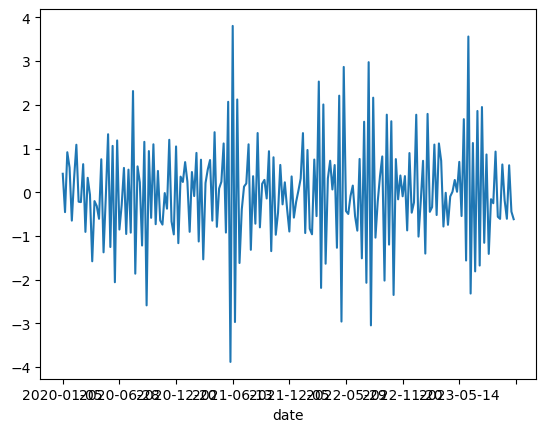

In [8]:
# Plot the time series
ts.plot();

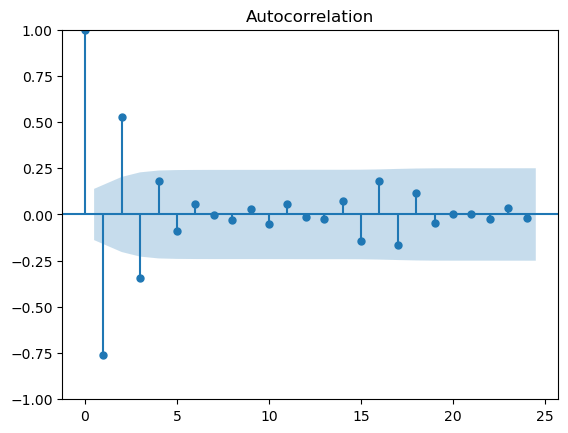

In [9]:
# Make acf plot of raw data to look for seasonality
tsa.graphics.plot_acf(ts);

In [10]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.612186,1,198,0.0,0.05,True


In [11]:
# same as above except check differencing with ndiffs
d = ndiffs(ts)
print (f'd = {d}')

d = 0


In [12]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

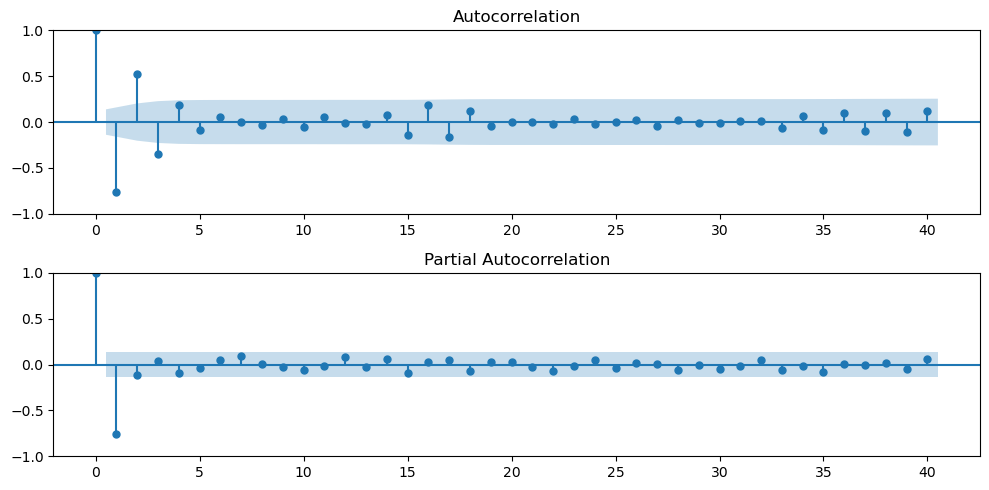

In [13]:
# Let's call our custom acf/pacf plot on our stationary (d = 0) data
plot_acf_pacf(ts);

### Train Test Split

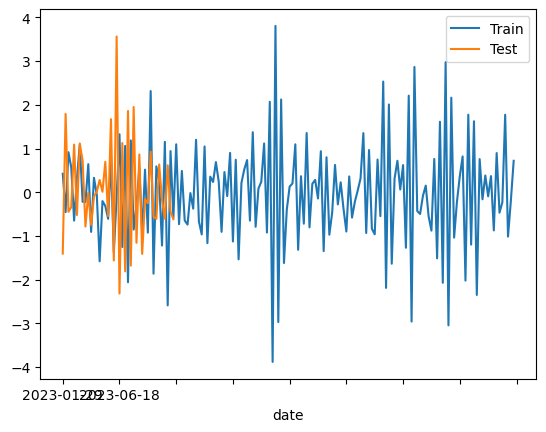

In [14]:
# tts
train, test = train_test_split(ts, test_size=.20)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [15]:
# First define the orders (p,d,q)
p = 0 # p is us ed for AR models (set to 0 for an MA only model)
d = 0 # no differcing was required to make the data stationary
q = 2 # q based on significant lags in ACF
# Now instantiate the model with the data and fit
ma_2_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ma_2_model

C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [16]:
# Obtain the parameters of the fit model
ma_2_model.params

const    -0.032084
ma.L1    -0.835154
ma.L2     0.340094
sigma2    0.680175
dtype: float64

In [17]:
# First define the orders (p,d,q)
p = 0 # p is us ed for AR models (set to 0 for an MA only model)
d = 0 # no differcing was required to make the data stationary
q = 2 # q based on significant lags in ACF
# Now instantiate the model with the data and fit
ma_2_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ma_2_model

C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [18]:
# Obtain the parameters of the fit model
ma_2_model.params

const    -0.032084
ma.L1    -0.835154
ma.L2     0.340094
sigma2    0.680175
dtype: float64

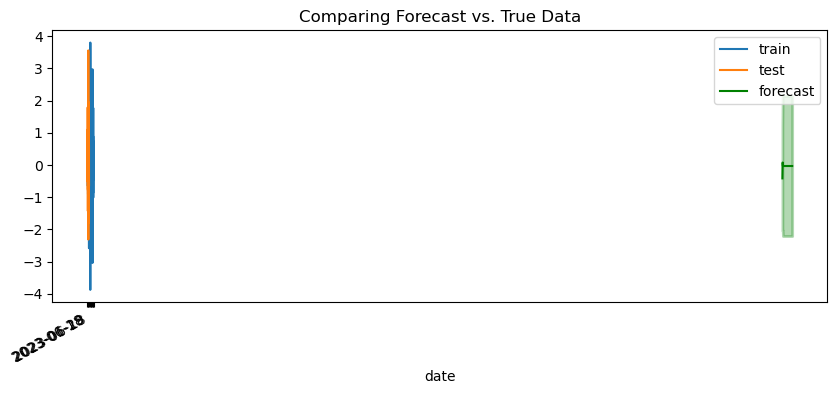

In [19]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = ma_2_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);

In [21]:
# Obtain summary of model
ma_2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                dollars   No. Observations:                  160
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -196.568
Date:                Sat, 28 Oct 2023   AIC                            401.135
Time:                        18:06:19   BIC                            413.436
Sample:                    01-05-2020   HQIC                           406.130
                         - 01-22-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0321      0.033     -0.968      0.333      -0.097       0.033
ma.L1         -0.8352      0.080    -10.421      0.000      -0.992      -0.678
ma.L2          0.3401      0.078      4.361      0.000       0.187       0.493
sigma2         0.6802      0.080      8.507      0.000       0.523       0.837
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.24   Prob(JB):                         0.78
Heteroskedasticity (H):               1.26   Skew:                             0.14
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

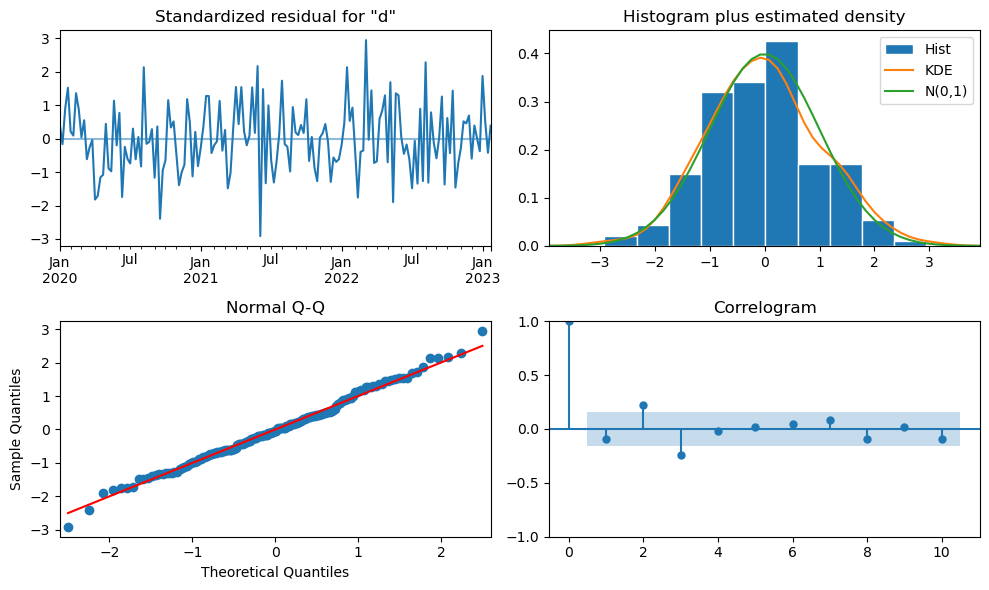

In [22]:
# Obtain diagnostic plots
fig = ma_2_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()